In [ ]:
#knowledge distillation!
#teacher net student net

In [1]:
import torch
from tqdm.auto import tqdm
import itertools
import random
import logging
import pickle
from os.path import expanduser
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision import transforms, datasets
import matplotlib
import matplotlib.pyplot as plt
home = expanduser("~/Model_compression")

In [2]:
class CIFAR3(Dataset):

    def __init__(self,split="train",transform=None):
      if split=="train":
        with open("cifar10_hst_train", 'rb') as fo:
          self.data = pickle.load(fo) 
      elif split=="val":
        with open("cifar10_hst_val", 'rb') as fo:
          self.data = pickle.load(fo)
      else:
        with open("cifar10_hst_test", 'rb') as fo:
          self.data = pickle.load(fo)
      
      self.transform = transform

    def __len__(self):
        return len(self.data['labels'])

    def __getitem__(self, idx):
        
        x = self.data['images'][idx,:]
        r = x[:1024].reshape(32,32)
        g = x[1024:2048].reshape(32,32)
        b = x[2048:].reshape(32,32)
        
        x = Tensor(np.stack([r,g,b]))

        if self.transform is not None:
          x = self.transform(x)
        
        y = self.data['labels'][idx,0]
        return x,y 

train_transform = transforms.Compose([
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[127.5, 127.5, 127.5],
                             std=[127.5, 127.5, 127.5])
    ])

test_transform = transforms.Compose([
        transforms.Normalize(mean=[127.5, 127.5, 127.5],
                             std=[127.5, 127.5, 127.5])
    ])

train_data = CIFAR3("train", transform=train_transform)
val_data = CIFAR3("val", transform=test_transform)
test_data = CIFAR3("test", transform=test_transform)

batch_size = 256
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


In [3]:
#teacher
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(4096, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3)
        self.batchnorm1 = nn.BatchNorm1d(512)
       
    def forward(self, x):
        #TODO
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.pool1(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool2(x)
        #print(x.shape, "###########1")
        nff = self.num_flat_features(x)
        x = x.view(-1 , nff)
        #print(x.shape, "###########")
        x = self.batchnorm1(self.fc1(x))
        x = self.relu5(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [4]:
#student
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.relu2 = nn.ReLU()
        # self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.relu3 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3)
        self.batchnorm1 = nn.BatchNorm1d(512)
       
    def forward(self, x):
        #TODO
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.pool1(self.conv2(x)))
        #print("#####################3", x.shape)
        #x = self.relu3(self.pool2(self.conv3(x)))
        nff = self.num_flat_features(x)
        x = x.view(-1 , nff)
        #print(x.shape, "###########")
        x = self.batchnorm1(self.fc1(x))
        x = self.relu5(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def my_tester(model, valloader, length):
    val_acc = 0
    val_loss = 0
    model.eval()
    device = 'cpu'
    for j,input in enumerate(valloader,0):

        x = input[0].to(device)
        y = input[1].type(torch.LongTensor).to(device)

        
        out = model(x)

        loss = criterion(out,y)
        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y).sum()

        val_acc += correct.item()
        val_loss += loss.item()

    val_acc /= length
    val_loss /= j
    return val_acc*100

In [ ]:

#trainiing student only 90% max
# Build model
smodel = SNet()


# Main training loop
optimizer = torch.optim.Adam(smodel.parameters(), lr=1e-4, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cpu')

smodel.to(device)
loss_log = []
acc_log = []
val_acc_log = []
val_loss_log = []
best_val_acc = 0.0
for i in range(50):

  # Run an epoch of training
  train_running_loss = 0
  train_running_acc = 0
  smodel.train()
  for j,input in enumerate(trainloader,0):
   
    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)
    out = smodel(x)
    loss = criterion(out,y)

    smodel.zero_grad()
    loss.backward()

    optimizer.step()

    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    train_running_loss += loss.item()
    train_running_acc += correct.item()
    loss_log.append(loss.item())
    acc_log.append(correct.item()/len(y))

  train_running_loss /= j
  train_running_acc /= len(train_data)

  # Evaluate on validation
  val_acc = 0
  val_loss = 0
  smodel.eval()
  for j,input in enumerate(valloader,0):

    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)

    
    out = smodel(x)

    loss = criterion(out,y)
    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    val_acc += correct.item()
    val_loss += loss.item()

  val_acc /= len(val_data)
  val_loss /= j
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    print("saving model")
    torch.save({
                'epoch': i+1,
                'model_state_dict': smodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, home+'/outputs/student_model2.pth')
    
  val_acc_log.append(val_acc)

  val_loss_log.append(val_loss)

  logging.info("[Epoch {:3}]   Loss:  {:8.4}     Train Acc:  {:8.4}%      Val Acc:  {:8.4}%".format(i,train_running_loss, train_running_acc*100,val_acc*100))


In [11]:
pytorch_total_params = sum(p.numel() for p in smodel.parameters())
print(pytorch_total_params)

528755


In [ ]:
import time
tic = time.perf_counter()
valaccu = my_tester(smodel, testloader, len(test_data))
toc = time.perf_counter()
print(valaccu, " orig time ", toc - tic)

In [ ]:
#training teacher only
import copy
model = Net()
model_dict = torch.load(home+'/outputs/best_mode.pth')
model.load_state_dict(model_dict['model_state_dict'])


# Main training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cpu')

model.to(device)
loss_log = []
acc_log = []
val_acc_log = []
val_loss_log = []
best_val_acc = 0.0
for i in range(50):

  # Run an epoch of training
  train_running_loss = 0
  train_running_acc = 0
  model.train()
  for j,input in enumerate(trainloader,0):
   
    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)
    out = model(x)
    loss = criterion(out,y)

    model.zero_grad()
    loss.backward()

    optimizer.step()

    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    train_running_loss += loss.item()
    train_running_acc += correct.item()
    loss_log.append(loss.item())
    acc_log.append(correct.item()/len(y))

  train_running_loss /= j
  train_running_acc /= len(train_data)

  # Evaluate on validation
  val_acc = 0
  val_loss = 0
  model.eval()
  for j,input in enumerate(valloader,0):

    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)

    
    out = model(x)

    loss = criterion(out,y)
    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    val_acc += correct.item()
    val_loss += loss.item()

  val_acc /= len(val_data)
  val_loss /= j
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    teacher_model = copy.deepcopy(model)
    print("saving model")
    torch.save({
                'epoch': i+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, home+'/outputs/teacher_model.pth')
    
  val_acc_log.append(val_acc)

  val_loss_log.append(val_loss)

  logging.info("[Epoch {:3}]   Loss:  {:8.4}     Train Acc:  {:8.4}%      Val Acc:  {:8.4}%".format(i,train_running_loss, train_running_acc*100,val_acc*100))


In [ ]:
import time
tic = time.perf_counter()
valaccu = my_tester(model, testloader, len(test_data))
toc = time.perf_counter()
print(valaccu, " orig time ", toc - tic)

Distillation begins

In [ ]:
# Set output directory and create if needed
import os
output_dir = "small_linear_model_distill1/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
### Define our custom loss function
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

def my_loss(scores, targets, T=1): #simple mse loss
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

def loss_kd(outputs, labels, teacher_outputs): #kl divergence loss
   temparature =1
   alpha = 0.5
   KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temparature, dim=1),F.softmax(teacher_outputs/temparature,dim=1)) *(alpha * temparature * temparature) + F.cross_entropy(outputs, labels) * (1. - alpha)
   return KD_loss

In [7]:
#trainiing distilled student 
# Build model
#editing
dsmodel = SNet()
# smodel_dict = torch.load(home+'/outputs/distil_original.pth')
# dsmodel.load_state_dict(smodel_dict['model_state_dict'])

criterion = torch.nn.CrossEntropyLoss()
teacher_model = Net()
tmodel_dict = torch.load(home+'/outputs/best_prune.pth')
teacher_model.load_state_dict(tmodel_dict['model_state_dict'])
teacher_model.eval()
# Main training loop
optimizer = torch.optim.Adam(dsmodel.parameters(), lr=1e-4, weight_decay=0.001)

device = torch.device('cpu')

dsmodel.to(device)
loss_log = []
acc_log = []
val_acc_log = []
val_loss_log = []
best_val_acc = 0.0
for i in range(150):

  # Run an epoch of training
  train_running_loss = 0
  train_running_acc = 0
  dsmodel.train()
  for j,input in enumerate(trainloader,0):
   
    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)
    out = dsmodel(x)
    targets = teacher_model(x)
    #loss = my_loss(out, targets)
    #loss = criterion(out, targets)
    loss = loss_kd(out, y, targets)

    dsmodel.zero_grad()
    loss.backward()

    optimizer.step()

    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    train_running_loss += loss.item()
    train_running_acc += correct.item()
    loss_log.append(loss.item())
    acc_log.append(correct.item()/len(y))

  train_running_loss /= j
  train_running_acc /= len(train_data)

  # Evaluate on validation
  val_acc = 0
  val_loss = 0
  dsmodel.eval()
  for j,input in enumerate(valloader,0):

    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)

    
    out = dsmodel(x)
    #targets = teacher_model(x)
    loss2 = criterion(out, y)
    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    val_acc += correct.item()
    val_loss += loss2.item()

  val_acc /= len(val_data)
  val_loss /= j
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    print("saving model")
    torch.save({
                'epoch': i+1,
                'model_state_dict': dsmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/hlab/Classes/outputs/distil_prune.pth')
    
  val_acc_log.append(val_acc)

  val_loss_log.append(val_loss)

  logging.info("[Epoch {:3}]   Loss:  {:8.4}     Train Acc:  {:8.4}%      Val Acc:  {:8.4}%".format(i,train_running_loss, train_running_acc*100,val_acc*100))


2023-06-16 17:26:08 INFO     [Epoch   0]   Loss:     0.468     Train Acc:     70.08%      Val Acc:      78.0%


saving model


2023-06-16 17:26:25 INFO     [Epoch   1]   Loss:    0.3339     Train Acc:     80.28%      Val Acc:      82.9%


saving model


2023-06-16 17:26:43 INFO     [Epoch   2]   Loss:    0.2928     Train Acc:     82.46%      Val Acc:      83.5%


saving model


2023-06-16 17:27:00 INFO     [Epoch   3]   Loss:      0.27     Train Acc:     84.05%      Val Acc:     86.15%


saving model


2023-06-16 17:27:16 INFO     [Epoch   4]   Loss:    0.2486     Train Acc:     85.17%      Val Acc:      87.2%


saving model


2023-06-16 17:27:33 INFO     [Epoch   5]   Loss:    0.2323     Train Acc:     86.12%      Val Acc:     87.45%


saving model


2023-06-16 17:27:48 INFO     [Epoch   6]   Loss:    0.2223     Train Acc:     86.95%      Val Acc:     88.65%


saving model


2023-06-16 17:28:03 INFO     [Epoch   7]   Loss:    0.2134     Train Acc:     87.49%      Val Acc:     88.35%
2023-06-16 17:28:17 INFO     [Epoch   8]   Loss:     0.208     Train Acc:     87.53%      Val Acc:     88.85%


saving model


2023-06-16 17:28:32 INFO     [Epoch   9]   Loss:    0.2015     Train Acc:     88.17%      Val Acc:      89.5%


saving model


2023-06-16 17:28:46 INFO     [Epoch  10]   Loss:    0.1945     Train Acc:     88.46%      Val Acc:      89.5%
2023-06-16 17:29:01 INFO     [Epoch  11]   Loss:    0.1887     Train Acc:      88.7%      Val Acc:      89.4%
2023-06-16 17:29:16 INFO     [Epoch  12]   Loss:    0.1854     Train Acc:     89.16%      Val Acc:      89.5%
2023-06-16 17:29:31 INFO     [Epoch  13]   Loss:    0.1818     Train Acc:     89.17%      Val Acc:      89.6%


saving model


2023-06-16 17:29:46 INFO     [Epoch  14]   Loss:    0.1792     Train Acc:     89.55%      Val Acc:     90.15%


saving model


2023-06-16 17:30:03 INFO     [Epoch  15]   Loss:    0.1745     Train Acc:     89.63%      Val Acc:     90.55%


saving model


2023-06-16 17:30:18 INFO     [Epoch  16]   Loss:    0.1712     Train Acc:     89.76%      Val Acc:      90.6%


saving model


2023-06-16 17:30:33 INFO     [Epoch  17]   Loss:    0.1693     Train Acc:     90.02%      Val Acc:     89.95%
2023-06-16 17:30:48 INFO     [Epoch  18]   Loss:    0.1642     Train Acc:     90.41%      Val Acc:     90.75%


saving model


2023-06-16 17:31:03 INFO     [Epoch  19]   Loss:    0.1596     Train Acc:     90.68%      Val Acc:     90.75%
2023-06-16 17:31:18 INFO     [Epoch  20]   Loss:    0.1583     Train Acc:     90.72%      Val Acc:     91.15%


saving model


2023-06-16 17:31:33 INFO     [Epoch  21]   Loss:    0.1558     Train Acc:     90.98%      Val Acc:     91.25%


saving model


2023-06-16 17:31:49 INFO     [Epoch  22]   Loss:     0.153     Train Acc:     91.16%      Val Acc:      91.1%
2023-06-16 17:32:04 INFO     [Epoch  23]   Loss:    0.1529     Train Acc:     90.96%      Val Acc:      90.9%
2023-06-16 17:32:18 INFO     [Epoch  24]   Loss:    0.1483     Train Acc:     91.31%      Val Acc:      91.6%


saving model


2023-06-16 17:32:33 INFO     [Epoch  25]   Loss:    0.1438     Train Acc:     91.48%      Val Acc:     91.55%
2023-06-16 17:32:49 INFO     [Epoch  26]   Loss:    0.1472     Train Acc:     91.27%      Val Acc:     91.25%
2023-06-16 17:33:04 INFO     [Epoch  27]   Loss:    0.1432     Train Acc:     91.66%      Val Acc:      91.3%
2023-06-16 17:33:19 INFO     [Epoch  28]   Loss:    0.1399     Train Acc:     91.99%      Val Acc:     91.75%


saving model


2023-06-16 17:33:34 INFO     [Epoch  29]   Loss:    0.1389     Train Acc:     91.96%      Val Acc:      91.3%
2023-06-16 17:33:49 INFO     [Epoch  30]   Loss:     0.135     Train Acc:     92.18%      Val Acc:     91.45%
2023-06-16 17:34:03 INFO     [Epoch  31]   Loss:    0.1334     Train Acc:     92.39%      Val Acc:     91.45%
2023-06-16 17:34:18 INFO     [Epoch  32]   Loss:    0.1335     Train Acc:     92.08%      Val Acc:     91.35%
2023-06-16 17:34:34 INFO     [Epoch  33]   Loss:    0.1314     Train Acc:     92.44%      Val Acc:     91.75%
2023-06-16 17:34:52 INFO     [Epoch  34]   Loss:    0.1288     Train Acc:     92.55%      Val Acc:      91.8%


saving model


2023-06-16 17:35:08 INFO     [Epoch  35]   Loss:    0.1269     Train Acc:     92.84%      Val Acc:      91.7%
2023-06-16 17:35:24 INFO     [Epoch  36]   Loss:    0.1272     Train Acc:     92.65%      Val Acc:     91.25%
2023-06-16 17:35:44 INFO     [Epoch  37]   Loss:     0.124     Train Acc:     92.92%      Val Acc:      91.5%
2023-06-16 17:36:02 INFO     [Epoch  38]   Loss:    0.1215     Train Acc:     93.21%      Val Acc:     91.85%


saving model


2023-06-16 17:36:20 INFO     [Epoch  39]   Loss:    0.1196     Train Acc:     93.15%      Val Acc:     91.75%
2023-06-16 17:36:38 INFO     [Epoch  40]   Loss:    0.1199     Train Acc:     93.32%      Val Acc:     91.65%
2023-06-16 17:36:56 INFO     [Epoch  41]   Loss:    0.1198     Train Acc:     92.97%      Val Acc:     92.15%


saving model


2023-06-16 17:37:15 INFO     [Epoch  42]   Loss:    0.1183     Train Acc:     93.21%      Val Acc:      91.9%
2023-06-16 17:37:32 INFO     [Epoch  43]   Loss:     0.115     Train Acc:     93.47%      Val Acc:      92.4%


saving model


2023-06-16 17:37:49 INFO     [Epoch  44]   Loss:    0.1152     Train Acc:     93.22%      Val Acc:     91.65%
2023-06-16 17:38:06 INFO     [Epoch  45]   Loss:    0.1144     Train Acc:     93.44%      Val Acc:      92.8%


saving model


2023-06-16 17:38:23 INFO     [Epoch  46]   Loss:    0.1128     Train Acc:     93.71%      Val Acc:     92.65%
2023-06-16 17:38:40 INFO     [Epoch  47]   Loss:    0.1112     Train Acc:     93.72%      Val Acc:      92.2%
2023-06-16 17:38:55 INFO     [Epoch  48]   Loss:    0.1099     Train Acc:     93.74%      Val Acc:     92.55%
2023-06-16 17:39:10 INFO     [Epoch  49]   Loss:    0.1107     Train Acc:     93.82%      Val Acc:      92.7%
2023-06-16 17:39:26 INFO     [Epoch  50]   Loss:    0.1065     Train Acc:     94.07%      Val Acc:     92.75%
2023-06-16 17:39:41 INFO     [Epoch  51]   Loss:    0.1062     Train Acc:     93.97%      Val Acc:      92.8%
2023-06-16 17:39:56 INFO     [Epoch  52]   Loss:    0.1061     Train Acc:     94.01%      Val Acc:     92.75%
2023-06-16 17:40:12 INFO     [Epoch  53]   Loss:    0.1044     Train Acc:     94.02%      Val Acc:     91.75%
2023-06-16 17:40:27 INFO     [Epoch  54]   Loss:    0.1047     Train Acc:     94.01%      Val Acc:      91.2%
2023-06-16

saving model


2023-06-16 17:41:51 INFO     [Epoch  59]   Loss:   0.09994     Train Acc:      94.5%      Val Acc:     92.85%
2023-06-16 17:42:08 INFO     [Epoch  60]   Loss:   0.09887     Train Acc:     94.49%      Val Acc:      92.2%
2023-06-16 17:42:23 INFO     [Epoch  61]   Loss:   0.09738     Train Acc:      94.6%      Val Acc:      92.6%
2023-06-16 17:42:38 INFO     [Epoch  62]   Loss:   0.09581     Train Acc:     94.81%      Val Acc:     92.65%
2023-06-16 17:42:53 INFO     [Epoch  63]   Loss:   0.09458     Train Acc:     94.78%      Val Acc:      92.5%
2023-06-16 17:43:08 INFO     [Epoch  64]   Loss:   0.09381     Train Acc:      94.9%      Val Acc:      92.3%
2023-06-16 17:43:23 INFO     [Epoch  65]   Loss:   0.09397     Train Acc:     94.82%      Val Acc:     93.35%


saving model


2023-06-16 17:43:38 INFO     [Epoch  66]   Loss:    0.0917     Train Acc:     94.94%      Val Acc:     92.85%
2023-06-16 17:43:54 INFO     [Epoch  67]   Loss:   0.09079     Train Acc:     94.87%      Val Acc:     92.95%
2023-06-16 17:44:10 INFO     [Epoch  68]   Loss:   0.09011     Train Acc:     95.08%      Val Acc:      92.9%
2023-06-16 17:44:25 INFO     [Epoch  69]   Loss:   0.09179     Train Acc:     95.07%      Val Acc:      92.7%
2023-06-16 17:44:41 INFO     [Epoch  70]   Loss:   0.09025     Train Acc:     95.05%      Val Acc:     92.85%
2023-06-16 17:44:58 INFO     [Epoch  71]   Loss:   0.08752     Train Acc:     95.33%      Val Acc:     92.85%
2023-06-16 17:45:16 INFO     [Epoch  72]   Loss:   0.08683     Train Acc:     95.28%      Val Acc:     92.75%
2023-06-16 17:45:33 INFO     [Epoch  73]   Loss:   0.08903     Train Acc:     95.16%      Val Acc:      93.0%
2023-06-16 17:45:51 INFO     [Epoch  74]   Loss:   0.08621     Train Acc:     95.13%      Val Acc:      93.0%
2023-06-16

saving model


2023-06-16 17:46:26 INFO     [Epoch  76]   Loss:   0.08301     Train Acc:     95.73%      Val Acc:      93.2%
2023-06-16 17:46:43 INFO     [Epoch  77]   Loss:    0.0861     Train Acc:     95.34%      Val Acc:      93.3%
2023-06-16 17:46:59 INFO     [Epoch  78]   Loss:   0.08394     Train Acc:      95.5%      Val Acc:      93.3%
2023-06-16 17:47:16 INFO     [Epoch  79]   Loss:   0.08432     Train Acc:     95.51%      Val Acc:     92.55%
2023-06-16 17:47:33 INFO     [Epoch  80]   Loss:   0.08275     Train Acc:     95.65%      Val Acc:      93.4%
2023-06-16 17:47:49 INFO     [Epoch  81]   Loss:   0.08062     Train Acc:     95.58%      Val Acc:      93.3%
2023-06-16 17:48:04 INFO     [Epoch  82]   Loss:   0.08001     Train Acc:     95.85%      Val Acc:      92.3%
2023-06-16 17:48:19 INFO     [Epoch  83]   Loss:   0.08265     Train Acc:      95.8%      Val Acc:      93.9%


saving model


2023-06-16 17:48:33 INFO     [Epoch  84]   Loss:   0.08026     Train Acc:      95.6%      Val Acc:     92.75%
2023-06-16 17:48:49 INFO     [Epoch  85]   Loss:   0.08105     Train Acc:     95.68%      Val Acc:     93.35%
2023-06-16 17:49:04 INFO     [Epoch  86]   Loss:   0.08026     Train Acc:     95.76%      Val Acc:      93.8%
2023-06-16 17:49:19 INFO     [Epoch  87]   Loss:   0.07809     Train Acc:     96.02%      Val Acc:     93.75%
2023-06-16 17:49:35 INFO     [Epoch  88]   Loss:   0.07716     Train Acc:     95.97%      Val Acc:      94.2%


saving model


2023-06-16 17:49:49 INFO     [Epoch  89]   Loss:   0.07859     Train Acc:     95.88%      Val Acc:     93.85%
2023-06-16 17:50:05 INFO     [Epoch  90]   Loss:   0.07791     Train Acc:     95.88%      Val Acc:     93.65%
2023-06-16 17:50:22 INFO     [Epoch  91]   Loss:   0.07515     Train Acc:      95.8%      Val Acc:     92.45%
2023-06-16 17:50:39 INFO     [Epoch  92]   Loss:   0.07556     Train Acc:     96.11%      Val Acc:     93.75%
2023-06-16 17:50:57 INFO     [Epoch  93]   Loss:   0.07447     Train Acc:      96.3%      Val Acc:      93.0%
2023-06-16 17:51:12 INFO     [Epoch  94]   Loss:   0.07646     Train Acc:     95.97%      Val Acc:      93.8%
2023-06-16 17:51:26 INFO     [Epoch  95]   Loss:   0.07426     Train Acc:     96.43%      Val Acc:     93.65%
2023-06-16 17:51:41 INFO     [Epoch  96]   Loss:   0.07347     Train Acc:     96.28%      Val Acc:      92.5%
2023-06-16 17:51:57 INFO     [Epoch  97]   Loss:   0.07387     Train Acc:      96.0%      Val Acc:      93.7%
2023-06-16

saving model


2023-06-16 17:55:38 INFO     [Epoch 110]   Loss:   0.06789     Train Acc:     96.45%      Val Acc:     94.35%
2023-06-16 17:55:55 INFO     [Epoch 111]   Loss:   0.06674     Train Acc:     96.77%      Val Acc:      94.3%
2023-06-16 17:56:13 INFO     [Epoch 112]   Loss:   0.06588     Train Acc:     96.56%      Val Acc:      93.7%
2023-06-16 17:56:30 INFO     [Epoch 113]   Loss:   0.06667     Train Acc:     96.61%      Val Acc:     93.75%
2023-06-16 17:56:48 INFO     [Epoch 114]   Loss:   0.06664     Train Acc:     96.56%      Val Acc:      93.8%
2023-06-16 17:57:05 INFO     [Epoch 115]   Loss:   0.06594     Train Acc:     96.77%      Val Acc:     94.15%
2023-06-16 17:57:22 INFO     [Epoch 116]   Loss:   0.06677     Train Acc:      96.7%      Val Acc:     94.25%
2023-06-16 17:57:39 INFO     [Epoch 117]   Loss:   0.06571     Train Acc:     96.86%      Val Acc:      94.2%
2023-06-16 17:57:56 INFO     [Epoch 118]   Loss:   0.06743     Train Acc:     96.53%      Val Acc:     93.55%
2023-06-16

saving model


2023-06-16 18:00:01 INFO     [Epoch 125]   Loss:   0.06324     Train Acc:     96.66%      Val Acc:     93.75%
2023-06-16 18:00:18 INFO     [Epoch 126]   Loss:   0.06194     Train Acc:     97.03%      Val Acc:     93.95%
2023-06-16 18:00:35 INFO     [Epoch 127]   Loss:    0.0612     Train Acc:     97.12%      Val Acc:     93.95%
2023-06-16 18:00:52 INFO     [Epoch 128]   Loss:   0.06144     Train Acc:     96.99%      Val Acc:      94.5%
2023-06-16 18:01:09 INFO     [Epoch 129]   Loss:   0.06153     Train Acc:     97.07%      Val Acc:      92.9%
2023-06-16 18:01:26 INFO     [Epoch 130]   Loss:   0.06333     Train Acc:     96.85%      Val Acc:      93.5%
2023-06-16 18:01:43 INFO     [Epoch 131]   Loss:   0.06289     Train Acc:     96.95%      Val Acc:      92.9%
2023-06-16 18:02:01 INFO     [Epoch 132]   Loss:   0.06221     Train Acc:      97.1%      Val Acc:     94.45%
2023-06-16 18:02:18 INFO     [Epoch 133]   Loss:   0.06237     Train Acc:     96.93%      Val Acc:      93.1%
2023-06-16

saving model


2023-06-16 18:03:29 INFO     [Epoch 137]   Loss:   0.05958     Train Acc:     97.17%      Val Acc:     94.25%
2023-06-16 18:03:47 INFO     [Epoch 138]   Loss:   0.05998     Train Acc:     97.08%      Val Acc:     93.85%
2023-06-16 18:04:04 INFO     [Epoch 139]   Loss:   0.06039     Train Acc:     97.09%      Val Acc:      93.7%
2023-06-16 18:04:22 INFO     [Epoch 140]   Loss:   0.06366     Train Acc:     96.87%      Val Acc:      93.5%
2023-06-16 18:04:40 INFO     [Epoch 141]   Loss:   0.05978     Train Acc:      97.1%      Val Acc:      94.5%
2023-06-16 18:04:58 INFO     [Epoch 142]   Loss:   0.05991     Train Acc:     97.02%      Val Acc:      93.4%
2023-06-16 18:05:16 INFO     [Epoch 143]   Loss:   0.05923     Train Acc:     97.17%      Val Acc:      93.1%
2023-06-16 18:05:33 INFO     [Epoch 144]   Loss:   0.05866     Train Acc:     97.46%      Val Acc:      94.5%
2023-06-16 18:05:50 INFO     [Epoch 145]   Loss:   0.05796     Train Acc:     97.38%      Val Acc:     93.15%
2023-06-16

In [8]:
pytorch_total_params = sum(p.numel() for p in dsmodel.parameters())
print(pytorch_total_params)

528755


In [12]:

def my_tester2(model, valloader, length):
    val_acc = 0
    val_loss = 0
    model.eval()
    device = 'cpu'
    criterion = torch.nn.CrossEntropyLoss()
    for j,input in enumerate(valloader,0):

        x = input[0].to(device)
        y = input[1].type(torch.LongTensor).to(device)

        
        out = model(x)

        loss = criterion(out,y)
        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y).sum()

        val_acc += correct.item()
        val_loss += loss.item()

    val_acc /= length
    val_loss /= j
    return val_acc*100

In [13]:
import time
tic = time.perf_counter()
valaccu = my_tester2(dsmodel, testloader, len(test_data))
toc = time.perf_counter()
print(valaccu, " orig time ", toc - tic)

92.53333333333333  orig time  0.2758444450009847


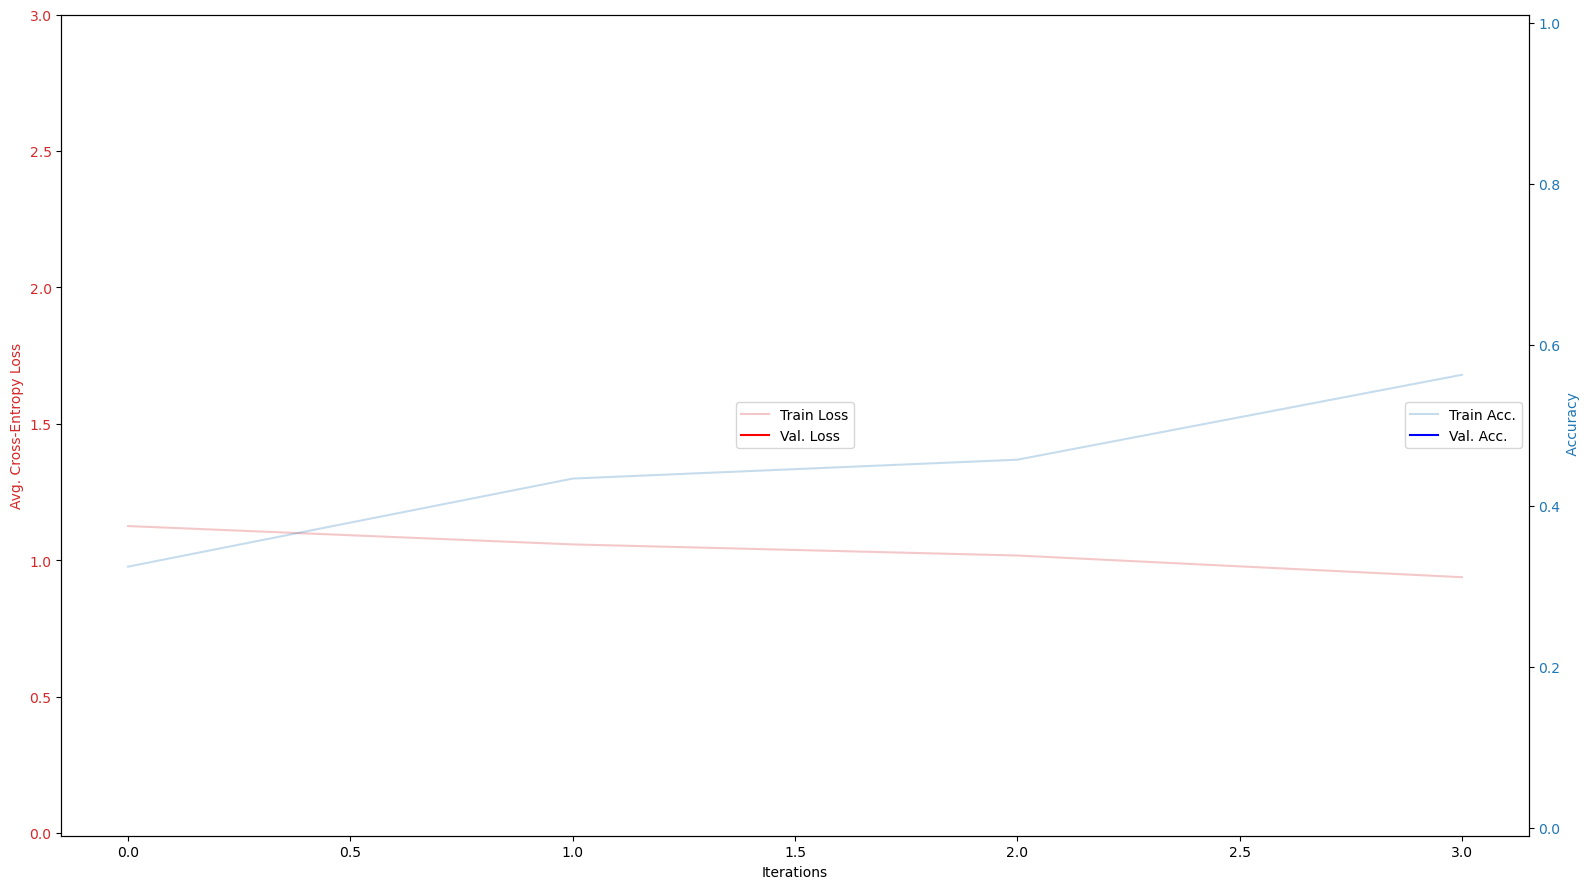

In [14]:
# Plot training and validation curves
fig, ax1 = plt.subplots(figsize=(16,9))
color = 'tab:red'
ax1.plot(range(len(loss_log)), loss_log, c=color, alpha=0.25, label="Train Loss")
ax1.plot([np.ceil((i+1)*len(train_data)/batch_size) for i in range(len(val_loss_log))], val_loss_log,c="red", label="Val. Loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Avg. Cross-Entropy Loss", c=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.01,3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(range(len(acc_log)), acc_log, c=color, label="Train Acc.", alpha=0.25)
ax2.plot([np.ceil((i+1)*len(train_data)/batch_size) for i in range(len(val_acc_log))], val_acc_log,c="blue", label="Val. Acc.")
ax2.set_ylabel(" Accuracy", c=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.01,1.01)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc="center")
ax2.legend(loc="center right")
plt.show()

In [ ]:
import time
tic = time.perf_counter()
valaccu = my_tester(dsmodel, testloader, len(test_data))
toc = time.perf_counter()
print(valaccu, " orig time ", toc - tic)

In [19]:
#student
class SMSNet(nn.Module):
    def __init__(self):
        super(SMSNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.relu2 = nn.ReLU()
        # self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.relu3 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)
        self.batchnorm1 = nn.BatchNorm1d(256)
       
    def forward(self, x):
        #TODO
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.pool1(self.conv2(x)))
        #print("#####################3", x.shape)
        #x = self.relu3(self.pool2(self.conv3(x)))
        nff = self.num_flat_features(x)
        x = x.view(-1 , nff)
        #print(x.shape, "###########")
        x = self.batchnorm1(self.fc1(x))
        x = self.relu5(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [20]:
#trainiing smaller distilled student 
# Build model
#editing
smsmodel = SMSNet()

criterion = torch.nn.CrossEntropyLoss()
steacher_model = SNet()
tsmodel_dict = torch.load(home+'/outputs/distil_prune.pth')
steacher_model.load_state_dict(tsmodel_dict['model_state_dict'])
steacher_model.eval()
# Main training loop
optimizer = torch.optim.Adam(smsmodel.parameters(), lr=1e-4, weight_decay=0.001)

device = torch.device('cpu')

dsmodel.to(device)
loss_log = []
acc_log = []
val_acc_log = []
val_loss_log = []
best_val_acc = 0.0
for i in range(150):

  # Run an epoch of training
  train_running_loss = 0
  train_running_acc = 0
  smsmodel.train()
  for j,input in enumerate(trainloader,0):
   
    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)
    out = smsmodel(x)
    targets = steacher_model(x)
    #loss = my_loss(out, targets)
    #loss = criterion(out, targets)
    loss = loss_kd(out, y, targets)

    smsmodel.zero_grad()
    loss.backward()

    optimizer.step()

    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    train_running_loss += loss.item()
    train_running_acc += correct.item()
    loss_log.append(loss.item())
    acc_log.append(correct.item()/len(y))

  train_running_loss /= j
  train_running_acc /= len(train_data)

  # Evaluate on validation
  val_acc = 0
  val_loss = 0
  smsmodel.eval()
  for j,input in enumerate(valloader,0):

    x = input[0].to(device)
    y = input[1].type(torch.LongTensor).to(device)

    
    out = smsmodel(x)
    #targets = teacher_model(x)
    loss2 = criterion(out, y)
    _, predicted = torch.max(out.data, 1)
    correct = (predicted == y).sum()

    val_acc += correct.item()
    val_loss += loss2.item()

  val_acc /= len(val_data)
  val_loss /= j
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    print("saving model")
    torch.save({
                'epoch': i+1,
                'model_state_dict': dsmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, home+'/outputs/nested_distil.pth')
    
  val_acc_log.append(val_acc)

  val_loss_log.append(val_loss)

  logging.info("[Epoch {:3}]   Loss:  {:8.4}     Train Acc:  {:8.4}%      Val Acc:  {:8.4}%".format(i,train_running_loss, train_running_acc*100,val_acc*100))


/home/hlab/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
2023-06-16 18:27:59 INFO     [Epoch   0]   Loss:    0.6194     Train Acc:     53.03%      Val Acc:      63.4%


saving model


2023-06-16 18:28:03 INFO     [Epoch   1]   Loss:    0.4593     Train Acc:     70.98%      Val Acc:     74.55%


saving model


2023-06-16 18:28:06 INFO     [Epoch   2]   Loss:    0.3952     Train Acc:     75.48%      Val Acc:      78.5%


saving model


2023-06-16 18:28:09 INFO     [Epoch   3]   Loss:    0.3613     Train Acc:     77.44%      Val Acc:     80.95%


saving model


2023-06-16 18:28:13 INFO     [Epoch   4]   Loss:    0.3358     Train Acc:     79.09%      Val Acc:     81.95%


saving model


2023-06-16 18:28:16 INFO     [Epoch   5]   Loss:    0.3208     Train Acc:     79.91%      Val Acc:     82.75%


saving model


2023-06-16 18:28:20 INFO     [Epoch   6]   Loss:    0.3105     Train Acc:     80.67%      Val Acc:     83.55%


saving model


2023-06-16 18:28:23 INFO     [Epoch   7]   Loss:    0.3028     Train Acc:     80.88%      Val Acc:      83.6%


saving model


2023-06-16 18:28:27 INFO     [Epoch   8]   Loss:     0.294     Train Acc:     81.61%      Val Acc:     83.65%


saving model


2023-06-16 18:28:30 INFO     [Epoch   9]   Loss:    0.2898     Train Acc:     81.69%      Val Acc:     84.15%


saving model


2023-06-16 18:28:34 INFO     [Epoch  10]   Loss:    0.2814     Train Acc:     82.23%      Val Acc:      84.0%
2023-06-16 18:28:37 INFO     [Epoch  11]   Loss:    0.2778     Train Acc:     82.34%      Val Acc:      84.8%


saving model


2023-06-16 18:28:41 INFO     [Epoch  12]   Loss:    0.2712     Train Acc:      83.0%      Val Acc:     84.95%


saving model


2023-06-16 18:28:44 INFO     [Epoch  13]   Loss:    0.2664     Train Acc:     83.26%      Val Acc:      85.1%


saving model


2023-06-16 18:28:48 INFO     [Epoch  14]   Loss:    0.2613     Train Acc:     83.68%      Val Acc:      85.5%


saving model


2023-06-16 18:28:52 INFO     [Epoch  15]   Loss:    0.2536     Train Acc:     83.96%      Val Acc:      85.7%


saving model


2023-06-16 18:28:56 INFO     [Epoch  16]   Loss:     0.252     Train Acc:     84.34%      Val Acc:      85.6%
2023-06-16 18:29:00 INFO     [Epoch  17]   Loss:    0.2471     Train Acc:     84.32%      Val Acc:     85.65%
2023-06-16 18:29:04 INFO     [Epoch  18]   Loss:    0.2451     Train Acc:     84.49%      Val Acc:      86.3%


saving model


2023-06-16 18:29:08 INFO     [Epoch  19]   Loss:    0.2399     Train Acc:      84.8%      Val Acc:      86.1%
2023-06-16 18:29:12 INFO     [Epoch  20]   Loss:    0.2366     Train Acc:     85.22%      Val Acc:     86.75%


saving model


2023-06-16 18:29:16 INFO     [Epoch  21]   Loss:     0.232     Train Acc:     85.59%      Val Acc:      86.8%


saving model


2023-06-16 18:29:20 INFO     [Epoch  22]   Loss:    0.2308     Train Acc:     85.56%      Val Acc:      86.9%


saving model


2023-06-16 18:29:24 INFO     [Epoch  23]   Loss:     0.225     Train Acc:     85.87%      Val Acc:     87.25%


saving model


2023-06-16 18:29:28 INFO     [Epoch  24]   Loss:    0.2264     Train Acc:     85.75%      Val Acc:     87.05%
2023-06-16 18:29:32 INFO     [Epoch  25]   Loss:    0.2236     Train Acc:     85.88%      Val Acc:     87.65%


saving model


2023-06-16 18:29:36 INFO     [Epoch  26]   Loss:    0.2206     Train Acc:     85.98%      Val Acc:     87.25%
2023-06-16 18:29:40 INFO     [Epoch  27]   Loss:    0.2163     Train Acc:     86.42%      Val Acc:      87.4%
2023-06-16 18:29:44 INFO     [Epoch  28]   Loss:     0.216     Train Acc:     86.34%      Val Acc:      87.4%
2023-06-16 18:29:49 INFO     [Epoch  29]   Loss:    0.2119     Train Acc:     86.35%      Val Acc:      87.9%


saving model


2023-06-16 18:29:53 INFO     [Epoch  30]   Loss:    0.2094     Train Acc:     86.83%      Val Acc:      87.8%
2023-06-16 18:29:57 INFO     [Epoch  31]   Loss:    0.2071     Train Acc:     87.07%      Val Acc:      88.2%


saving model


2023-06-16 18:30:01 INFO     [Epoch  32]   Loss:     0.202     Train Acc:     87.44%      Val Acc:      88.0%
2023-06-16 18:30:05 INFO     [Epoch  33]   Loss:    0.2036     Train Acc:     87.02%      Val Acc:     88.15%
2023-06-16 18:30:09 INFO     [Epoch  34]   Loss:       0.2     Train Acc:     87.64%      Val Acc:      87.9%
2023-06-16 18:30:13 INFO     [Epoch  35]   Loss:    0.1998     Train Acc:      87.5%      Val Acc:     87.65%
2023-06-16 18:30:17 INFO     [Epoch  36]   Loss:    0.1972     Train Acc:     87.49%      Val Acc:     88.05%
2023-06-16 18:30:21 INFO     [Epoch  37]   Loss:    0.1946     Train Acc:     87.96%      Val Acc:     88.15%
2023-06-16 18:30:25 INFO     [Epoch  38]   Loss:    0.1931     Train Acc:     87.72%      Val Acc:      88.5%


saving model


2023-06-16 18:30:29 INFO     [Epoch  39]   Loss:    0.1888     Train Acc:     88.29%      Val Acc:     89.15%


saving model


2023-06-16 18:30:33 INFO     [Epoch  40]   Loss:    0.1911     Train Acc:     87.82%      Val Acc:     88.95%
2023-06-16 18:30:37 INFO     [Epoch  41]   Loss:    0.1887     Train Acc:     88.44%      Val Acc:      88.9%
2023-06-16 18:30:40 INFO     [Epoch  42]   Loss:     0.184     Train Acc:     88.57%      Val Acc:      88.9%
2023-06-16 18:30:44 INFO     [Epoch  43]   Loss:    0.1888     Train Acc:     88.35%      Val Acc:      89.4%


saving model


2023-06-16 18:30:48 INFO     [Epoch  44]   Loss:    0.1862     Train Acc:     88.48%      Val Acc:     89.65%


saving model


2023-06-16 18:30:52 INFO     [Epoch  45]   Loss:    0.1823     Train Acc:     88.85%      Val Acc:     89.45%
2023-06-16 18:30:55 INFO     [Epoch  46]   Loss:    0.1807     Train Acc:     88.49%      Val Acc:     89.25%
2023-06-16 18:30:59 INFO     [Epoch  47]   Loss:    0.1803     Train Acc:     88.63%      Val Acc:      89.6%
2023-06-16 18:31:02 INFO     [Epoch  48]   Loss:    0.1775     Train Acc:     89.05%      Val Acc:      90.0%


saving model


2023-06-16 18:31:06 INFO     [Epoch  49]   Loss:    0.1777     Train Acc:     88.98%      Val Acc:      90.1%


saving model


2023-06-16 18:31:09 INFO     [Epoch  50]   Loss:    0.1752     Train Acc:     89.05%      Val Acc:     89.75%
2023-06-16 18:31:12 INFO     [Epoch  51]   Loss:    0.1738     Train Acc:     89.34%      Val Acc:      90.1%
2023-06-16 18:31:16 INFO     [Epoch  52]   Loss:    0.1721     Train Acc:     89.26%      Val Acc:      89.8%
2023-06-16 18:31:19 INFO     [Epoch  53]   Loss:    0.1718     Train Acc:      89.2%      Val Acc:     90.25%


saving model


2023-06-16 18:31:23 INFO     [Epoch  54]   Loss:    0.1695     Train Acc:     89.28%      Val Acc:      89.9%
2023-06-16 18:31:26 INFO     [Epoch  55]   Loss:    0.1665     Train Acc:     89.73%      Val Acc:     90.05%
2023-06-16 18:31:30 INFO     [Epoch  56]   Loss:    0.1692     Train Acc:     89.51%      Val Acc:      90.1%
2023-06-16 18:31:33 INFO     [Epoch  57]   Loss:    0.1677     Train Acc:     89.93%      Val Acc:     90.05%
2023-06-16 18:31:37 INFO     [Epoch  58]   Loss:    0.1661     Train Acc:     89.66%      Val Acc:     90.05%
2023-06-16 18:31:40 INFO     [Epoch  59]   Loss:    0.1635     Train Acc:     89.88%      Val Acc:      90.2%
2023-06-16 18:31:44 INFO     [Epoch  60]   Loss:    0.1636     Train Acc:     89.92%      Val Acc:      90.7%


saving model


2023-06-16 18:31:47 INFO     [Epoch  61]   Loss:     0.163     Train Acc:      89.7%      Val Acc:     91.05%


saving model


2023-06-16 18:31:51 INFO     [Epoch  62]   Loss:    0.1606     Train Acc:     90.12%      Val Acc:      90.8%
2023-06-16 18:31:54 INFO     [Epoch  63]   Loss:    0.1601     Train Acc:     90.18%      Val Acc:      90.7%
2023-06-16 18:31:58 INFO     [Epoch  64]   Loss:    0.1569     Train Acc:     90.22%      Val Acc:      90.6%
2023-06-16 18:32:01 INFO     [Epoch  65]   Loss:    0.1588     Train Acc:     90.19%      Val Acc:     90.35%
2023-06-16 18:32:04 INFO     [Epoch  66]   Loss:     0.157     Train Acc:     89.83%      Val Acc:      90.7%
2023-06-16 18:32:08 INFO     [Epoch  67]   Loss:    0.1566     Train Acc:     90.21%      Val Acc:      90.5%
2023-06-16 18:32:11 INFO     [Epoch  68]   Loss:    0.1567     Train Acc:     90.18%      Val Acc:     90.65%
2023-06-16 18:32:14 INFO     [Epoch  69]   Loss:    0.1545     Train Acc:     90.23%      Val Acc:     90.75%
2023-06-16 18:32:18 INFO     [Epoch  70]   Loss:    0.1546     Train Acc:     90.42%      Val Acc:     90.65%
2023-06-16

saving model


2023-06-16 18:32:26 INFO     [Epoch  72]   Loss:    0.1501     Train Acc:     90.88%      Val Acc:      91.0%
2023-06-16 18:32:29 INFO     [Epoch  73]   Loss:    0.1506     Train Acc:      90.8%      Val Acc:      91.1%
2023-06-16 18:32:33 INFO     [Epoch  74]   Loss:    0.1474     Train Acc:     90.97%      Val Acc:     90.95%
2023-06-16 18:32:37 INFO     [Epoch  75]   Loss:    0.1496     Train Acc:      90.7%      Val Acc:      91.0%
2023-06-16 18:32:40 INFO     [Epoch  76]   Loss:    0.1491     Train Acc:     90.75%      Val Acc:      90.8%
2023-06-16 18:32:43 INFO     [Epoch  77]   Loss:    0.1497     Train Acc:     90.65%      Val Acc:      91.1%
2023-06-16 18:32:47 INFO     [Epoch  78]   Loss:    0.1472     Train Acc:     91.06%      Val Acc:     90.95%
2023-06-16 18:32:50 INFO     [Epoch  79]   Loss:     0.147     Train Acc:      91.0%      Val Acc:      91.0%
2023-06-16 18:32:54 INFO     [Epoch  80]   Loss:    0.1457     Train Acc:     90.84%      Val Acc:      91.4%


saving model


2023-06-16 18:32:57 INFO     [Epoch  81]   Loss:    0.1464     Train Acc:     91.03%      Val Acc:      91.1%
2023-06-16 18:33:01 INFO     [Epoch  82]   Loss:    0.1436     Train Acc:     91.14%      Val Acc:      91.3%
2023-06-16 18:33:04 INFO     [Epoch  83]   Loss:    0.1422     Train Acc:     91.39%      Val Acc:      91.1%
2023-06-16 18:33:07 INFO     [Epoch  84]   Loss:    0.1416     Train Acc:     91.23%      Val Acc:      91.5%


saving model


2023-06-16 18:33:11 INFO     [Epoch  85]   Loss:    0.1402     Train Acc:     91.56%      Val Acc:     91.85%


saving model


2023-06-16 18:33:14 INFO     [Epoch  86]   Loss:      0.14     Train Acc:     91.31%      Val Acc:      91.6%
2023-06-16 18:33:18 INFO     [Epoch  87]   Loss:    0.1402     Train Acc:     91.42%      Val Acc:     91.55%
2023-06-16 18:33:21 INFO     [Epoch  88]   Loss:    0.1392     Train Acc:     91.45%      Val Acc:     91.55%
2023-06-16 18:33:25 INFO     [Epoch  89]   Loss:    0.1381     Train Acc:     91.33%      Val Acc:     91.35%
2023-06-16 18:33:28 INFO     [Epoch  90]   Loss:    0.1384     Train Acc:     91.45%      Val Acc:     91.65%
2023-06-16 18:33:32 INFO     [Epoch  91]   Loss:    0.1384     Train Acc:     91.42%      Val Acc:     91.55%
2023-06-16 18:33:35 INFO     [Epoch  92]   Loss:    0.1361     Train Acc:      91.9%      Val Acc:     91.35%
2023-06-16 18:33:39 INFO     [Epoch  93]   Loss:    0.1367     Train Acc:     91.52%      Val Acc:      92.2%


saving model


2023-06-16 18:33:43 INFO     [Epoch  94]   Loss:    0.1365     Train Acc:     91.44%      Val Acc:     92.05%
2023-06-16 18:33:46 INFO     [Epoch  95]   Loss:    0.1353     Train Acc:     91.73%      Val Acc:     92.15%
2023-06-16 18:33:49 INFO     [Epoch  96]   Loss:    0.1324     Train Acc:     91.99%      Val Acc:      91.6%
2023-06-16 18:33:53 INFO     [Epoch  97]   Loss:    0.1317     Train Acc:     92.24%      Val Acc:      92.0%
2023-06-16 18:33:56 INFO     [Epoch  98]   Loss:    0.1312     Train Acc:     91.95%      Val Acc:      91.8%
2023-06-16 18:34:00 INFO     [Epoch  99]   Loss:    0.1332     Train Acc:     91.68%      Val Acc:     91.85%
2023-06-16 18:34:04 INFO     [Epoch 100]   Loss:    0.1331     Train Acc:     92.05%      Val Acc:      92.0%
2023-06-16 18:34:08 INFO     [Epoch 101]   Loss:     0.128     Train Acc:     92.19%      Val Acc:      92.0%
2023-06-16 18:34:12 INFO     [Epoch 102]   Loss:    0.1307     Train Acc:     91.95%      Val Acc:      91.9%
2023-06-16

saving model


2023-06-16 18:34:44 INFO     [Epoch 111]   Loss:    0.1245     Train Acc:     92.62%      Val Acc:      92.2%
2023-06-16 18:34:48 INFO     [Epoch 112]   Loss:    0.1268     Train Acc:     92.18%      Val Acc:     92.25%
2023-06-16 18:34:51 INFO     [Epoch 113]   Loss:    0.1238     Train Acc:     92.48%      Val Acc:     92.25%
2023-06-16 18:34:55 INFO     [Epoch 114]   Loss:    0.1255     Train Acc:     92.31%      Val Acc:      92.6%


saving model


2023-06-16 18:34:59 INFO     [Epoch 115]   Loss:    0.1244     Train Acc:     92.66%      Val Acc:     92.15%
2023-06-16 18:35:03 INFO     [Epoch 116]   Loss:     0.124     Train Acc:     92.54%      Val Acc:     91.85%
2023-06-16 18:35:06 INFO     [Epoch 117]   Loss:    0.1205     Train Acc:     92.81%      Val Acc:     92.65%


saving model


2023-06-16 18:35:10 INFO     [Epoch 118]   Loss:    0.1213     Train Acc:     92.84%      Val Acc:     92.65%
2023-06-16 18:35:14 INFO     [Epoch 119]   Loss:    0.1201     Train Acc:      92.6%      Val Acc:     92.45%
2023-06-16 18:35:17 INFO     [Epoch 120]   Loss:    0.1195     Train Acc:     92.76%      Val Acc:      92.7%


saving model


2023-06-16 18:35:21 INFO     [Epoch 121]   Loss:    0.1223     Train Acc:     93.02%      Val Acc:     92.75%


saving model


2023-06-16 18:35:25 INFO     [Epoch 122]   Loss:    0.1188     Train Acc:     92.68%      Val Acc:     92.25%
2023-06-16 18:35:30 INFO     [Epoch 123]   Loss:     0.118     Train Acc:     93.09%      Val Acc:      92.3%
2023-06-16 18:35:33 INFO     [Epoch 124]   Loss:    0.1188     Train Acc:     92.94%      Val Acc:      92.5%
2023-06-16 18:35:37 INFO     [Epoch 125]   Loss:    0.1204     Train Acc:     92.54%      Val Acc:     92.85%


saving model


2023-06-16 18:35:41 INFO     [Epoch 126]   Loss:     0.116     Train Acc:     93.01%      Val Acc:      92.7%
2023-06-16 18:35:44 INFO     [Epoch 127]   Loss:    0.1199     Train Acc:     92.71%      Val Acc:      92.3%
2023-06-16 18:35:48 INFO     [Epoch 128]   Loss:    0.1187     Train Acc:     92.95%      Val Acc:     92.95%


saving model


2023-06-16 18:35:51 INFO     [Epoch 129]   Loss:     0.117     Train Acc:      93.0%      Val Acc:      92.9%
2023-06-16 18:35:55 INFO     [Epoch 130]   Loss:    0.1161     Train Acc:     92.98%      Val Acc:     92.85%
2023-06-16 18:35:58 INFO     [Epoch 131]   Loss:    0.1185     Train Acc:     92.71%      Val Acc:      93.0%


saving model


2023-06-16 18:36:02 INFO     [Epoch 132]   Loss:    0.1164     Train Acc:     93.05%      Val Acc:     92.65%
2023-06-16 18:36:05 INFO     [Epoch 133]   Loss:    0.1149     Train Acc:     93.14%      Val Acc:      92.8%
2023-06-16 18:36:09 INFO     [Epoch 134]   Loss:    0.1142     Train Acc:     93.52%      Val Acc:      92.6%
2023-06-16 18:36:12 INFO     [Epoch 135]   Loss:    0.1146     Train Acc:     93.42%      Val Acc:     92.45%
2023-06-16 18:36:17 INFO     [Epoch 136]   Loss:    0.1132     Train Acc:     93.36%      Val Acc:      92.1%
2023-06-16 18:36:21 INFO     [Epoch 137]   Loss:    0.1142     Train Acc:     93.18%      Val Acc:     92.75%
2023-06-16 18:36:25 INFO     [Epoch 138]   Loss:    0.1108     Train Acc:     93.52%      Val Acc:      92.6%
2023-06-16 18:36:29 INFO     [Epoch 139]   Loss:    0.1124     Train Acc:     93.23%      Val Acc:      92.8%
2023-06-16 18:36:33 INFO     [Epoch 140]   Loss:    0.1102     Train Acc:     93.56%      Val Acc:      92.2%
2023-06-16

saving model


2023-06-16 18:37:08 INFO     [Epoch 149]   Loss:    0.1099     Train Acc:     93.58%      Val Acc:      93.0%


In [21]:
pytorch_total_params = sum(p.numel() for p in smsmodel.parameters())
print(pytorch_total_params)

133019
